In [1]:
# Pipeline for combining all np.sum calculations for ePix Runs 21-28 (except 24 & 27)
# Last ran 07/21/2025

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Runs and file paths
runs = [21, 22, 23, 25, 26, 28]
file_template = "/sdf/group/rfar/timodo/ePix_Runs_ErrorPlot_Data/part0_run_{}.npz"

# Plot colors and labels
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
labels = [f'Run-{r}' for r in runs]

In [4]:
# Helper function to compute mean and std at each unique time point
def compute_errorbars_by_time(time, com):
    unique_times = np.unique(time)
    means = []
    stds = []
    for ut in unique_times:
        vals = com[time == ut]
        means.append(np.mean(vals))
        stds.append(np.std(vals))
    return unique_times, np.array(means), np.array(stds)

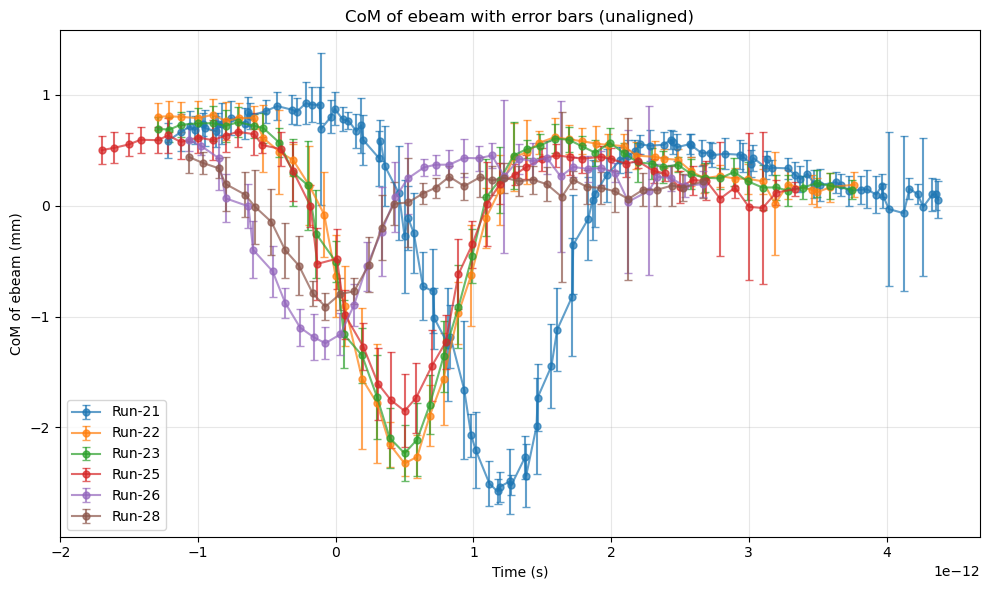

In [5]:
plt.figure(figsize=(10, 6))

for i, run in enumerate(runs):
    data = np.load(file_template.format(run))
    time = data['t_part']
    com = data['img_com_2_part_100um']
    
    uniq_t, mean_vals, std_vals = compute_errorbars_by_time(time, com)

    plt.errorbar(uniq_t, mean_vals, yerr=std_vals, fmt='o-', capsize=3,
                 color=colors[i], label=labels[i], alpha=0.7, markersize=5)

plt.xlabel('Time (s)')
plt.ylabel('CoM of ebeam (mm)')
plt.title('CoM of ebeam with error bars (unaligned)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

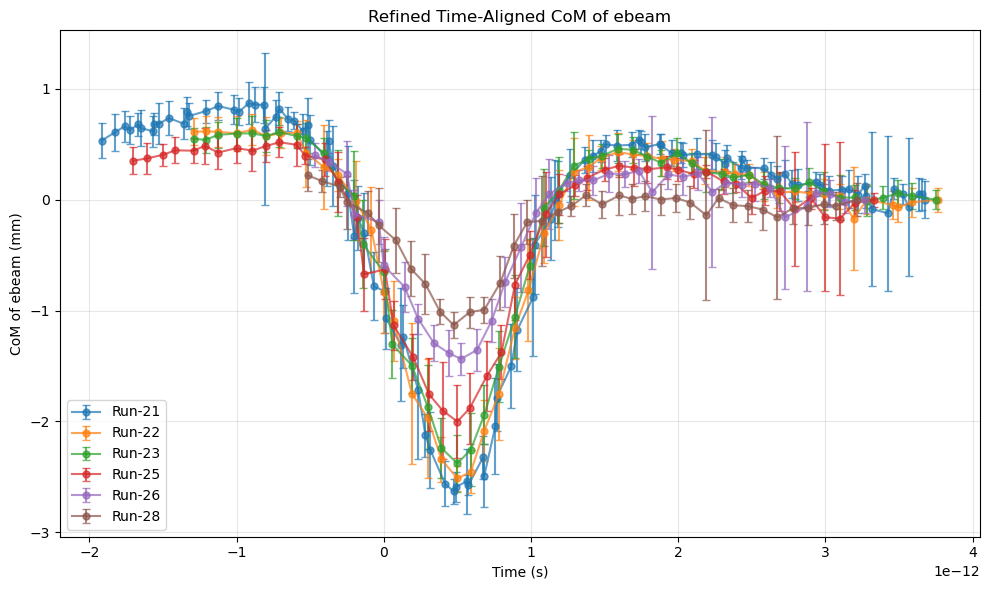

<ErrorbarContainer object of 3 artists>

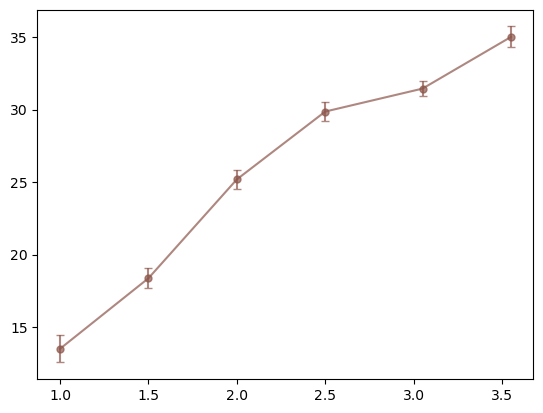

In [36]:
# Plot the curves with refined manual time alignment
plt.figure(figsize=(10, 6))

# Refined time shifts for better alignment (in seconds)
time_shifts = {
    21: -0.7e-12,
    26:  0.6e-12,
    28:  0.55e-12,
    # default is 0 shift for others
}

# Reference runs for vertical alignment (already aligned)
reference_runs = [22, 23, 25]
reference_means = []
align_start, align_end = 0, 2e-12

# Compute vertical alignment target mean
for run in reference_runs:
    data = np.load(file_template.format(run))
    time = data['t_part']
    com = data['img_com_2_part_100um']
    mask = (time >= align_start) & (time <= align_end)
    reference_means.append(np.mean(com[mask]))
maxvalsSTDs=[]
target_mean = np.mean(reference_means)
maxvals=[]
minvals=[]
pumps=[3.55,3.05,2.5,2,1.5,1]
# Plot each run with both time and vertical alignment
for i, run in enumerate(runs):
    data = np.load(file_template.format(run))
    time = data['t_part']
    com = data['img_com_2_part_100um']

    uniq_t, mean_vals, std_vals = compute_errorbars_by_time(time, com)

    # Apply time shift
    t_shift = time_shifts.get(run, 0.0)
    shifted_t = uniq_t + t_shift

    # Apply vertical shift
    mask = (shifted_t >= align_start) & (shifted_t <= align_end)
    current_mean = np.mean(mean_vals[mask])
    v_shift = target_mean - current_mean
    aligned_vals = mean_vals + v_shift

    # Plot with error bars
    plt.errorbar(shifted_t, aligned_vals-aligned_vals[-1], yerr=std_vals, fmt='o-', capsize=3,
                 color=colors[i], label=labels[i], alpha=0.7, markersize=5)
    maxD=np.max(aligned_vals-aligned_vals[-1])
    minD=np.min(aligned_vals-aligned_vals[-1])
    maxvals.append(maxD)
    minvals.append(minD)
    maxvalsSTDs.append(std_vals[np.argmax(aligned_vals - aligned_vals[-1])])
plt.xlabel('Time (s)')
plt.ylabel('CoM of ebeam (mm)')
plt.title('Refined Time-Aligned CoM of ebeam')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
yy=np.array(maxvals) - np.array(minvals)
xx=pumps[::-1]
yy=yy[::-1]
plt.errorbar(xx, yy*10, yerr=np.array(maxvalsSTDs)*5, fmt='o-', capsize=3,
                 color=colors[i], label=labels[i], alpha=0.7, markersize=5)

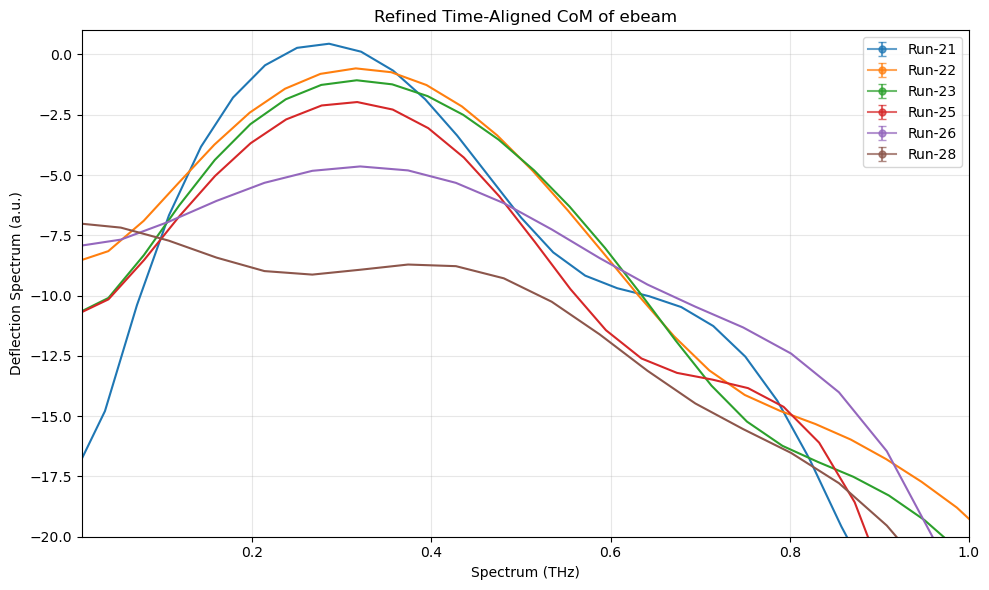

In [19]:
plt.figure(figsize=(10, 6))
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
# Refined time shifts for better alignment (in seconds)
time_shifts = {
    21: -0.7e-12,
    26:  0.6e-12,
    28:  0.55e-12,
    # default is 0 shift for others
}

# Reference runs for vertical alignment (already aligned)
reference_runs = [22, 23, 25]
reference_means = []
align_start, align_end = 0, 2e-12

# Compute vertical alignment target mean
for run in reference_runs:
    data = np.load(file_template.format(run))
    time = data['t_part']
    com = data['img_com_2_part_100um']
    mask = (time >= align_start) & (time <= align_end)
    reference_means.append(np.mean(com[mask]))

target_mean = np.mean(reference_means)

# Plot each run with both time and vertical alignment
for i, run in enumerate(runs):
    data = np.load(file_template.format(run))
    time = data['t_part']
    com = data['img_com_2_part_100um']

    uniq_t, mean_vals, std_vals = compute_errorbars_by_time(time, com)

    # Apply time shift
    t_shift = time_shifts.get(run, 0.0)
    shifted_t = uniq_t + t_shift

    # Apply vertical shift
    mask = (shifted_t >= align_start) & (shifted_t <= align_end)
    current_mean = np.mean(mean_vals[mask])
    v_shift = target_mean - current_mean
    aligned_vals = mean_vals + v_shift

    # Plot with error bars
    plt.errorbar(shifted_t, aligned_vals-aligned_vals[-1], yerr=std_vals, fmt='o-', capsize=3,
                 color=colors[i], label=labels[i], alpha=0.7, markersize=5)
    
    
    upsample_factor = 10
    N_interp = len(shifted_t) * upsample_factor
    x_interp = np.linspace(shifted_t[0], shifted_t[-1], N_interp)
    interp_func = interp1d(shifted_t, aligned_vals-aligned_vals[-1], kind='cubic')
    y_interp = interp_func(x_interp)

# Zero padding
    pad_factor = 5  # e.g., add 4x zeros
    N_total = N_interp * pad_factor
    y_padded = np.zeros(N_total)
    y_padded[:N_interp] = y_interp  # signal + zeros

# FFT
    dt = x_interp[1] - x_interp[0]
    fs = 1.0 / dt
    freq = np.fft.fftfreq(N_total, d=dt)
    Y = np.fft.fft(y_padded)

# One-sided FFT
    half = N_total // 2
    Y_mag = 2.0 / N_interp * np.abs(Y[:half])  # normalize by original signal length
    freq = freq[:half]

# Plot
    plt.plot(freq/1e12, 20*np.log10(Y_mag))


plt.xlabel('Spectrum (THz)')
plt.ylabel('Deflection Spectrum (a.u.)')
plt.title('Refined Time-Aligned CoM of ebeam')
plt.legend()
plt.xlim([0.01,1])
plt.ylim([-20,1])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Find time difference between peak (max) and trough (min) for each curve
peak_trough_times = []

for i, run in enumerate(runs):
    data = np.load(file_template.format(run))
    time = data['t_part']
    com = data['img_com_2_part_100um']
    uniq_t, mean_vals, std_vals = compute_errorbars_by_time(time, com)

    # Apply time shift
    t_shift = time_shifts.get(run, 0.0)
    shifted_t = uniq_t + t_shift

    # Apply vertical shift
    # Use same align window as previously used
    mask = (shifted_t >= align_start) & (shifted_t <= align_end)
    current_mean = np.mean(mean_vals[mask])
    aligned_vals = mean_vals + target_mean - current_mean

    peak_idx = np.argmax(aligned_vals)
    trough_idx = np.argmin(aligned_vals)
    peak_time = shifted_t[peak_idx]
    trough_time = shifted_t[trough_idx]
    delta_t = peak_time - trough_time   # seconds

    peak_trough_times.append((run, peak_time, trough_time, delta_t))
    print(f"Run-{run}: Peak at {peak_time:.3e}s, Trough at {trough_time:.3e}s, Δt = {delta_t:.3e}s")

In [ ]:
# Slope of CoM vs. time in μm/fs for each curve (aligned)
slope_results = []

for i, run in enumerate(runs):
    data = np.load(file_template.format(run))
    time = data['t_part']
    com = data['img_com_2_part_100um']
    uniq_t, mean_vals, std_vals = compute_errorbars_by_time(time, com)

    # Apply time shift
    t_shift = time_shifts.get(run, 0.0)
    shifted_t = uniq_t + t_shift

    # Apply vertical shift for alignment
    mask = (shifted_t >= align_start) & (shifted_t <= align_end)
    current_mean = np.mean(mean_vals[mask])
    aligned_vals = mean_vals + target_mean - current_mean

    # Convert x (time) axis from seconds to femtoseconds
    t_fs = shifted_t * 1e15
    # Convert y (CoM) from mm to μm
    y_um = aligned_vals * 1e3

    # Linear fit (μm/fs)
    slope, intercept = np.polyfit(t_fs, y_um, deg=1)
    slope_results.append((run, slope))
    print(f"Run-{run}: Slope = {slope:.3e} μm/fs")

In [ ]:
# Store results
peak_trough_times = []
slope_results = []

for i, run in enumerate(runs):
    data = np.load(file_template.format(run))
    time = data['t_part']
    com = data['img_com_2_part_100um']
    uniq_t, mean_vals, std_vals = compute_errorbars_by_time(time, com)

    # Apply time shift for alignment
    t_shift = time_shifts.get(run, 0.0)
    shifted_t = uniq_t + t_shift

    # Apply vertical alignment (same as used in previous plots)
    mask = (shifted_t >= align_start) & (shifted_t <= align_end)
    current_mean = np.mean(mean_vals[mask])
    v_shift = target_mean - current_mean
    aligned_vals = mean_vals + v_shift

    # Peak and trough calculation
    peak_idx = np.argmax(aligned_vals)
    trough_idx = np.argmin(aligned_vals)
    peak_time = shifted_t[peak_idx]
    trough_time = shifted_t[trough_idx]
    delta_t = peak_time - trough_time   # seconds

    # Slope calculation: convert time (s→fs), com (mm→μm)
    t_fs = shifted_t * 1e15
    y_um = aligned_vals * 1e3
    slope, _ = np.polyfit(t_fs, y_um, 1)  # μm/fs

    peak_trough_times.append((run, peak_time, trough_time, delta_t))
    slope_results.append((run, slope))

    print(f"Run-{run}: Peak at {peak_time:.3e} s, Trough at {trough_time:.3e} s, Δt = {delta_t:.3e} s, Slope = {slope:.3e} μm/fs")